In [1]:
import pickle, os, sys, math
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from samples.data_sim import remove_feature
from city_pv_uni_modal import CityPV_UniModal
from city_pv_multi_modal import CityPV_MultiModal
from feature_selection import tune_pacf, rfecv_selection
from utils_pv import get_available_modules, get_available_inverters, visualize_pv, visualize_env
from samples.data_sim import PVDataset

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


## Generating Data
### Train-Test Split
* only in March and April
* 15 years of data
* different training scenarios using 2 weeks, 1 year, 5 years, and 15 years of data for training
* always test on last week of March and last week of April

### Notes:
* 24 clients instead of 5
* reduced dev on azimuth
* added more variation in other parameters
* sml has 150 samples


In [2]:
exp_name = 'PV_UniModal'
num_clients = 24
city_names = ['Lausanne']
env_dict = {'city_names':city_names,
            'num_clients': num_clients, 'num_modes': len(city_names),
            'tilt_std': 5, 'az_std':15, 'weather_dev':0.1,
            'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':1,
            'module_name': ['Canadian_Solar_CS5P_220M___2009_'],
            'inverter_name': ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
            'lags':[], 'months':[3,4], 'hours':np.arange(7, 17), 
            'train_scenarios':{'sml':{'m_train':150, 'train_years':[2019], 'exclude_last_year':True},
                            '1y':{'m_train':None, 'train_years':[2019], 'exclude_last_year':True},
                            '5y':{'m_train':None, 'train_years':np.arange(2015, 2020), 'exclude_last_year':True},
                            }}

env_dict = PVDataset(env_dict).generate_clients_data()
print('\n'+env_dict['info'])

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))

filename_env = os.getcwd() + "/../../saved_results/" + exp_name + "_nicolas_env_raw"
# save env
file = open(filename_env, 'wb')
pickle.dump(env_dict, file)
msg = '[INFO] saved data for {:2.0f} clients'.format(env_dict['num_clients'])

[INFO] generating data for Lausanne
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used
[WARNING] AR not used

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 1.0, same module_name, same inverter_name, 
sml has 150 train and 140 validation samples
1y has 610 train and 140 validation samples
5y has 3050 train and 140 validation samples


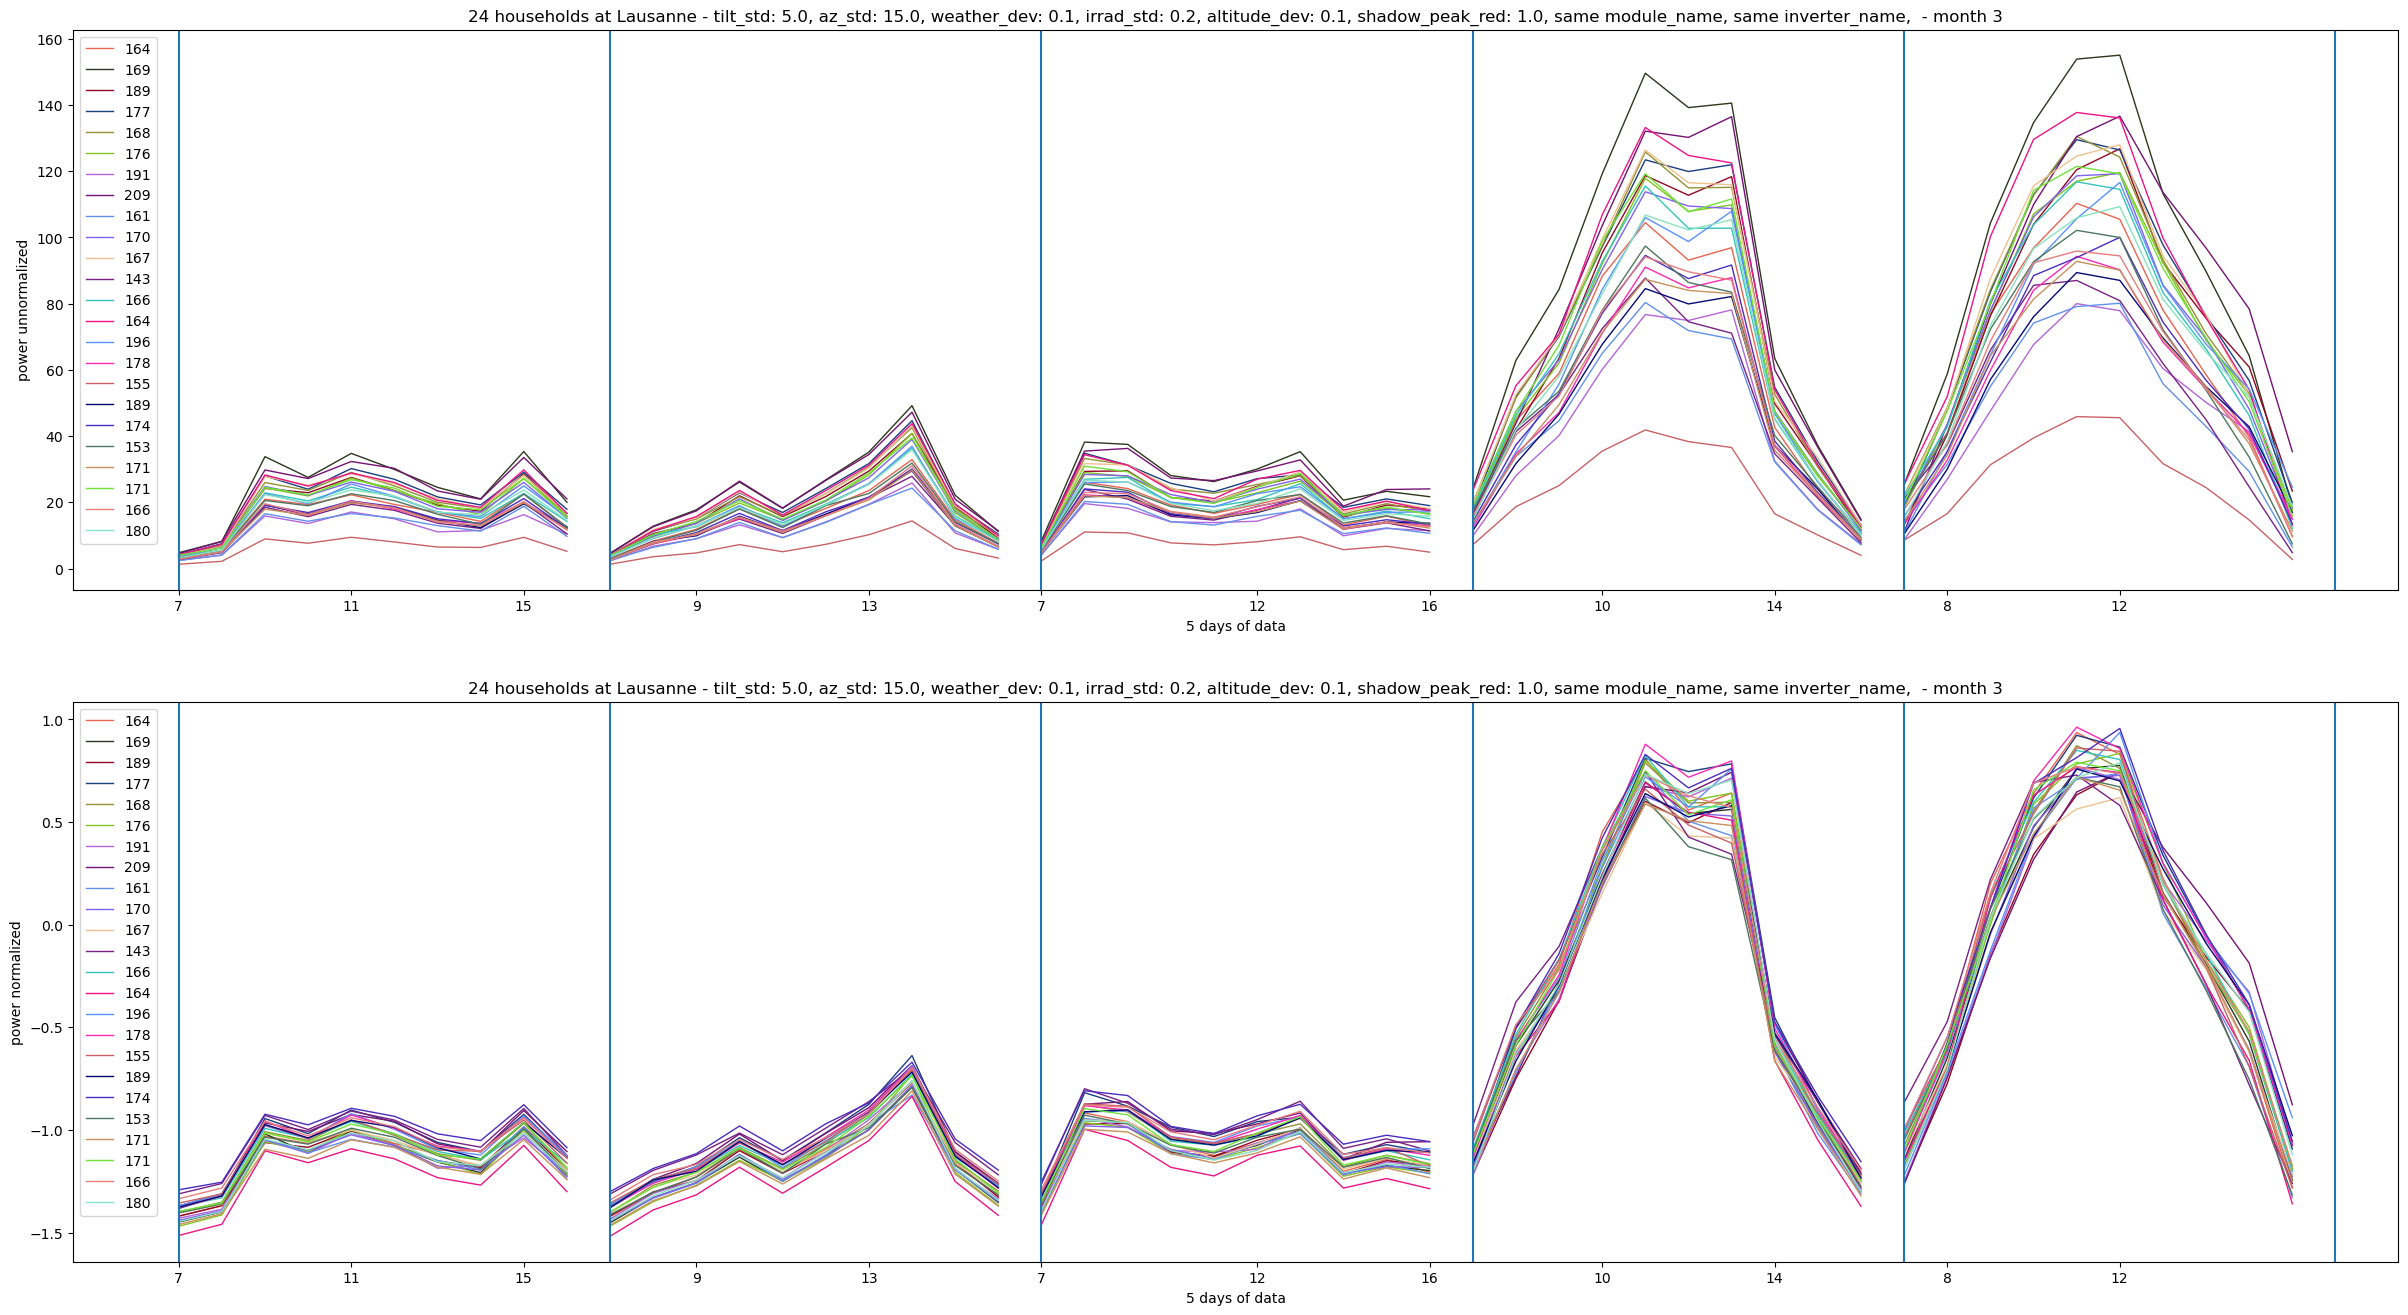

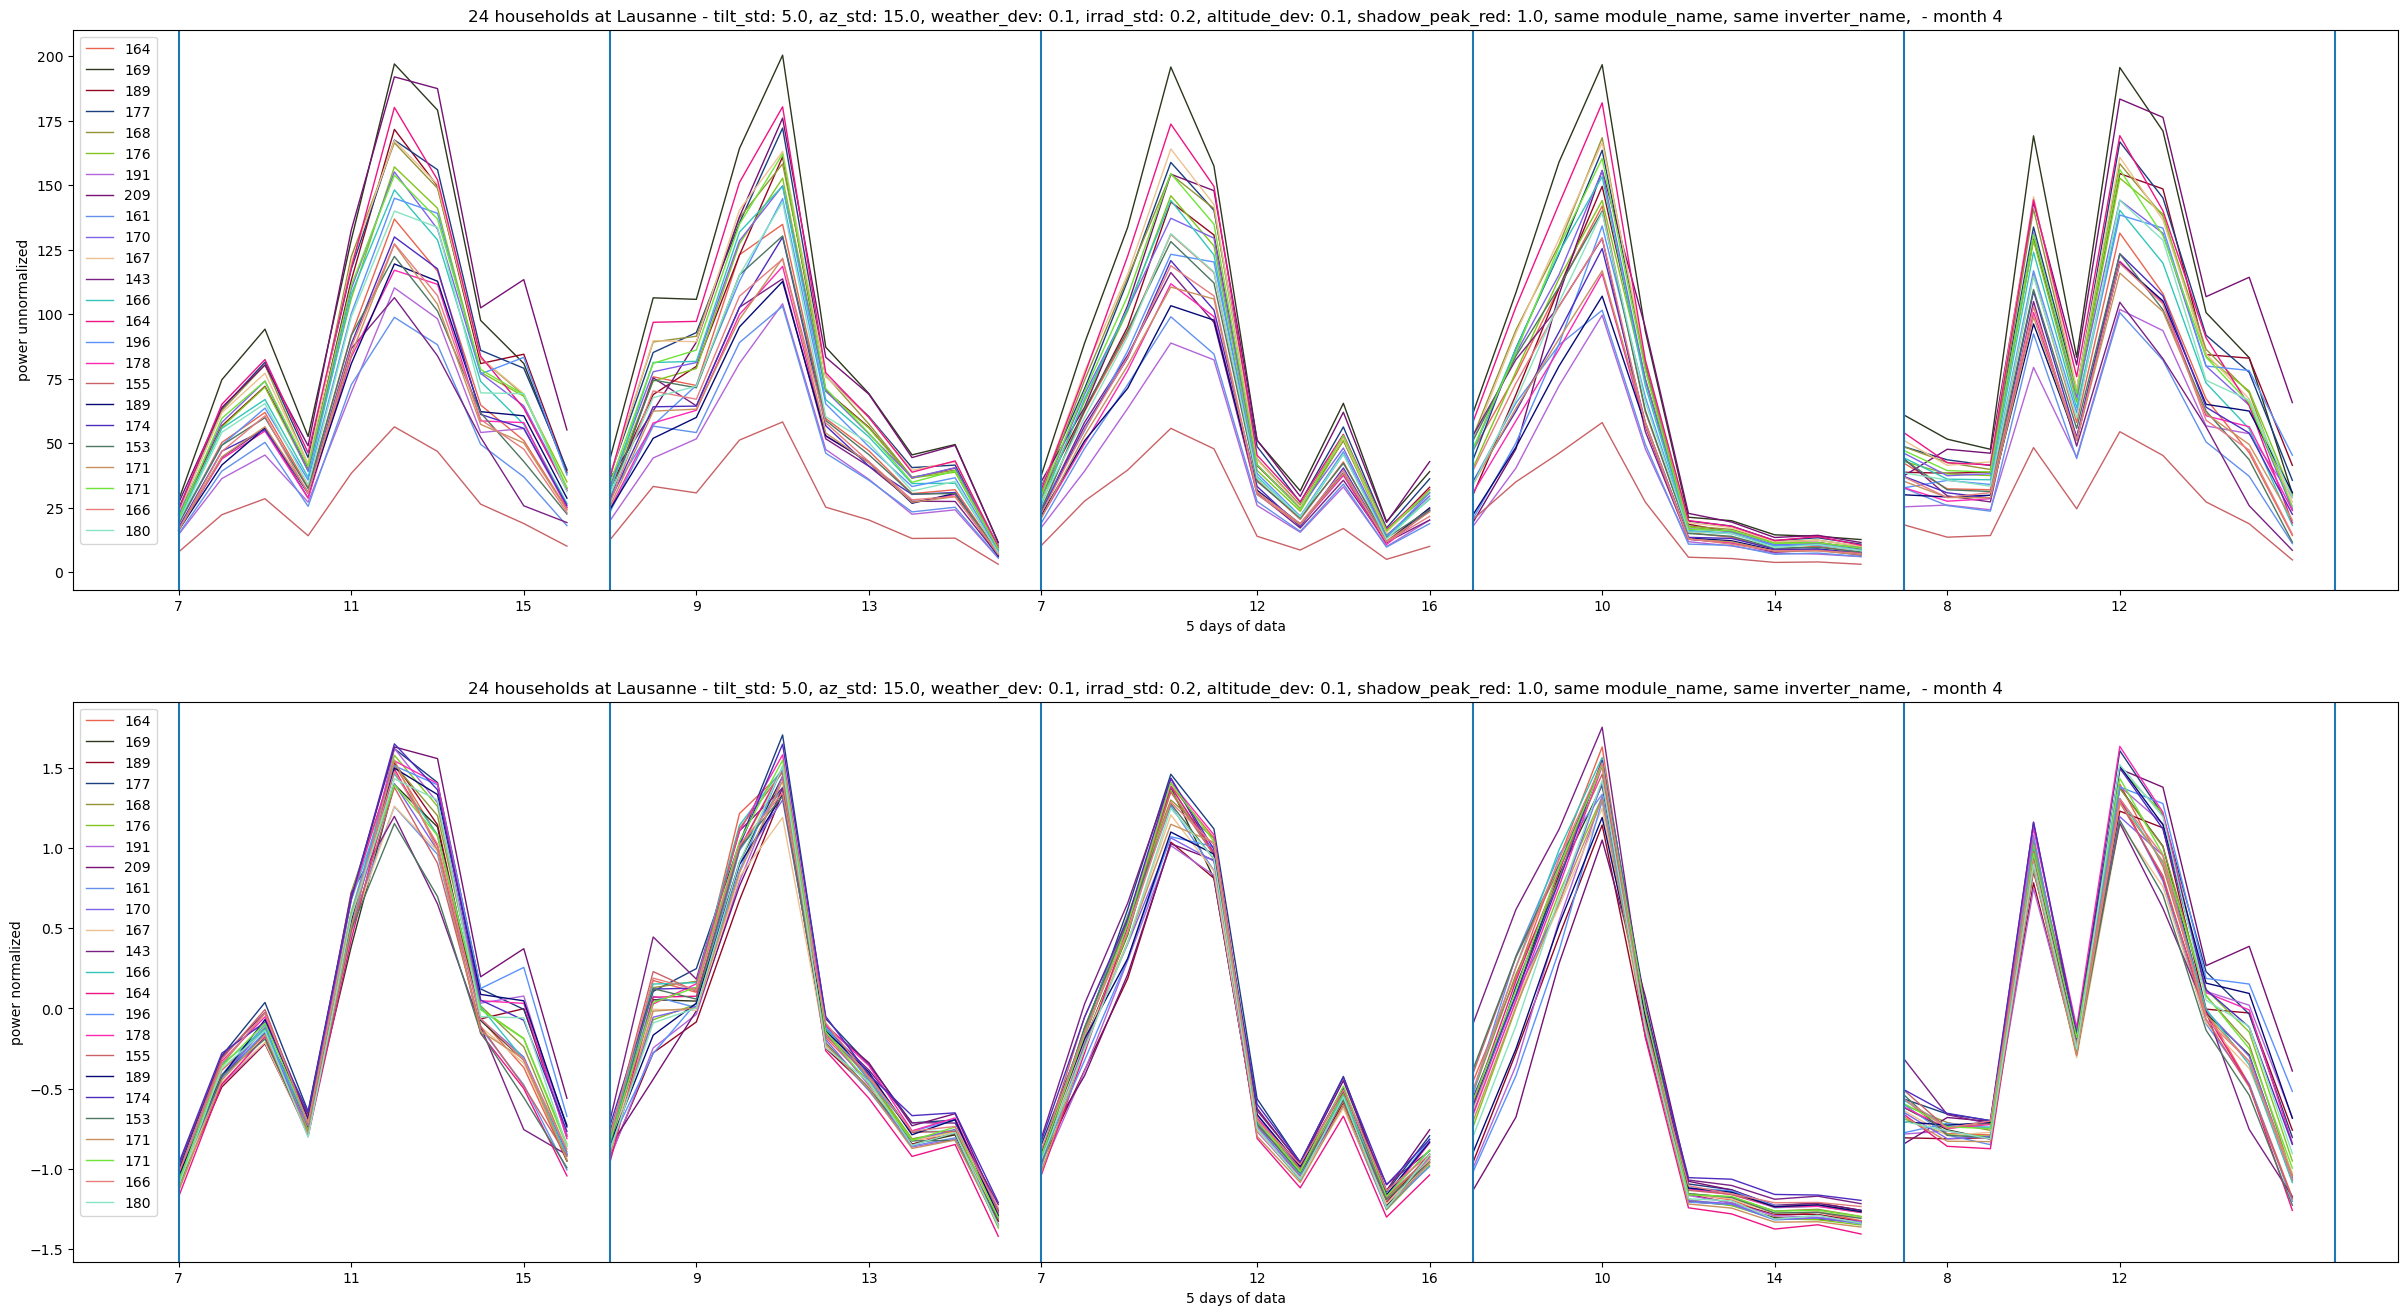

In [4]:
visualize_env(env_dict, num_days=5)

## Feature Engineering

### 1. Selecting a subset of weather info and temporal information 
* run on a subset of clients to reduce computations
* analysis based on 5 years data 

In [4]:
# reconstruct houses
from house_pv import reconstruct_house
scenario_name_recons='5y'
# run on a subset of clients to reduce computations
clients_subset = [12, 14, 15, 17, 22]
houses = [None] * env_dict['num_clients']
for client_num in clients_subset:
    houses[client_num] = reconstruct_house(
                            env_dict=env_dict, 
                            client_num=client_num, 
                            scenario_name=scenario_name_recons)
print('[INFO] reconstructed the ' + scenario_name_recons + ' scenario.')

[INFO] reconstructed the 5y scenario.


Check correlation between features

[RES] observations:
H_sun and hourofd_y are highly correlated (|corr|=0.79)
H_sun and station_irrad_direct_prev are slightly correlated (|corr|=0.68)
H_sun and station_irrad_diffuse_prev are highly correlated (|corr|=0.84)
T2m and dayofy_y are slightly correlated (|corr|=0.67)
hourofd_y and station_irrad_direct_prev are slightly correlated (|corr|=0.52)
hourofd_y and station_irrad_diffuse_prev are slightly correlated (|corr|=0.74)
station_irrad_direct_prev and station_irrad_diffuse_prev are slightly correlated (|corr|=0.52)


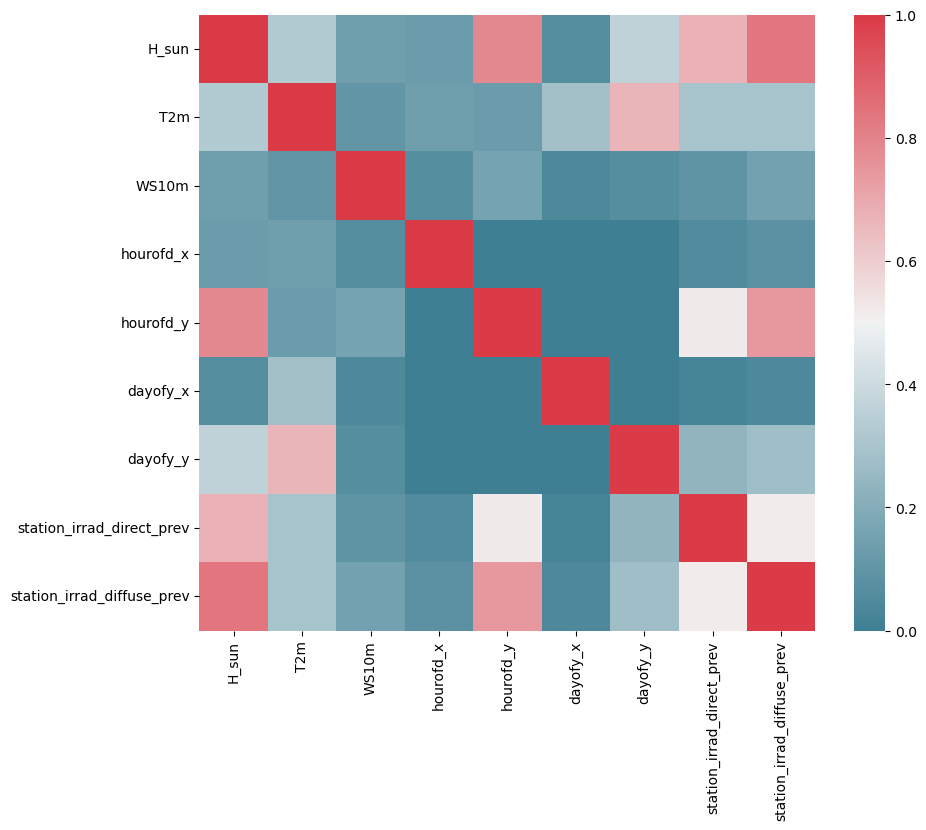

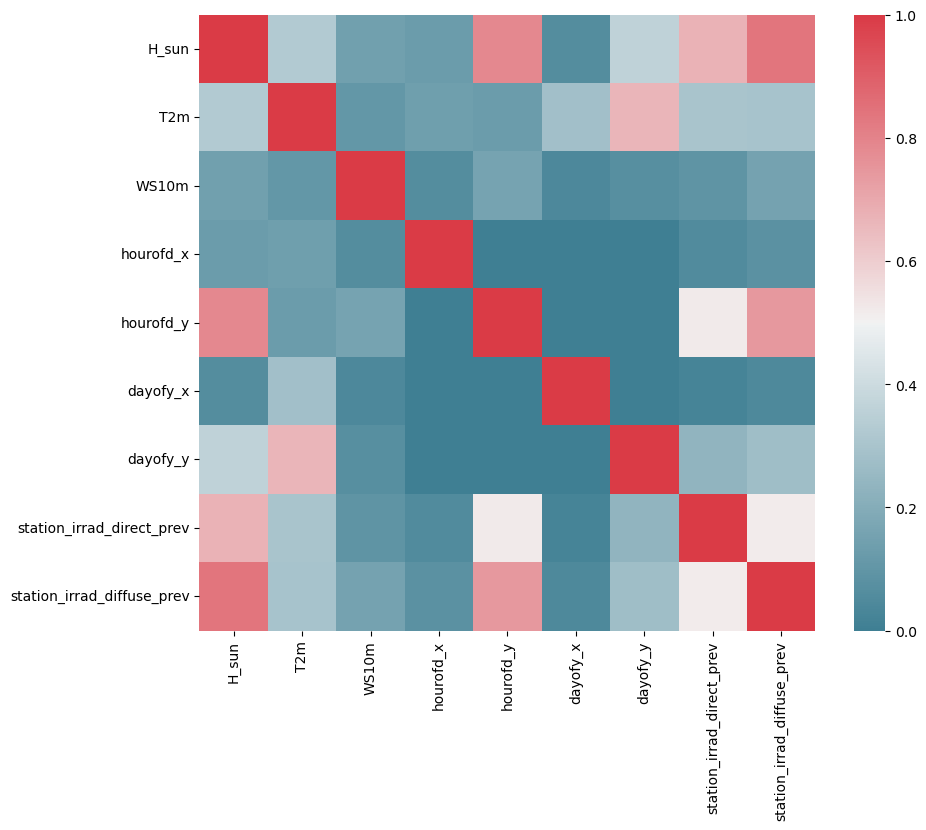

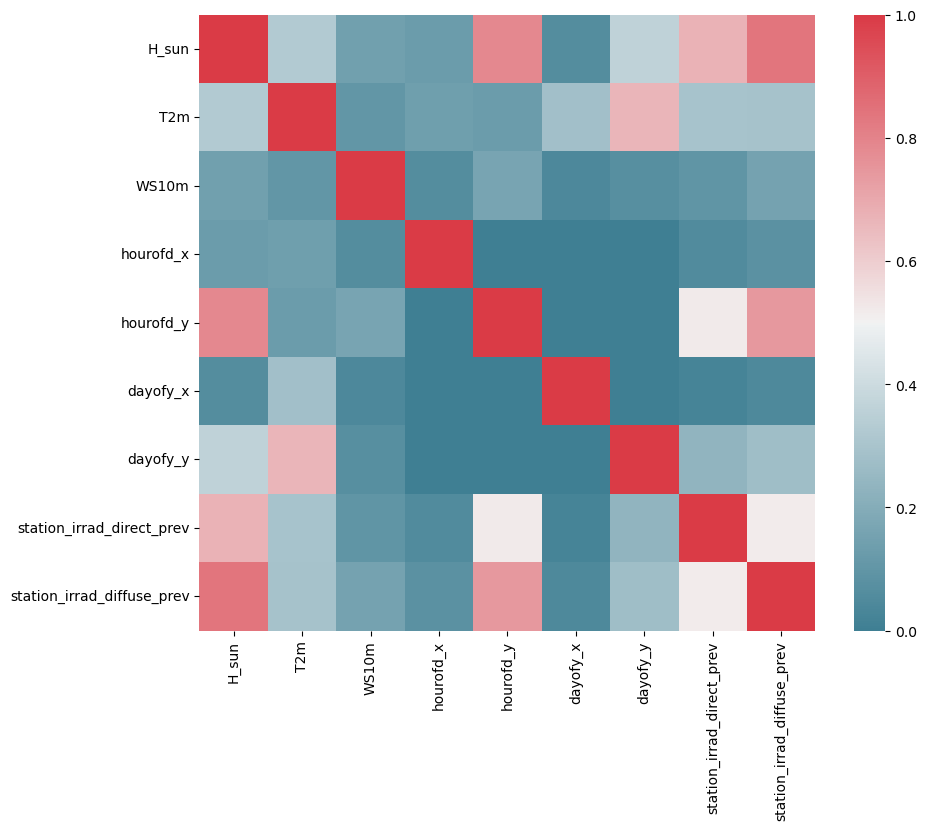

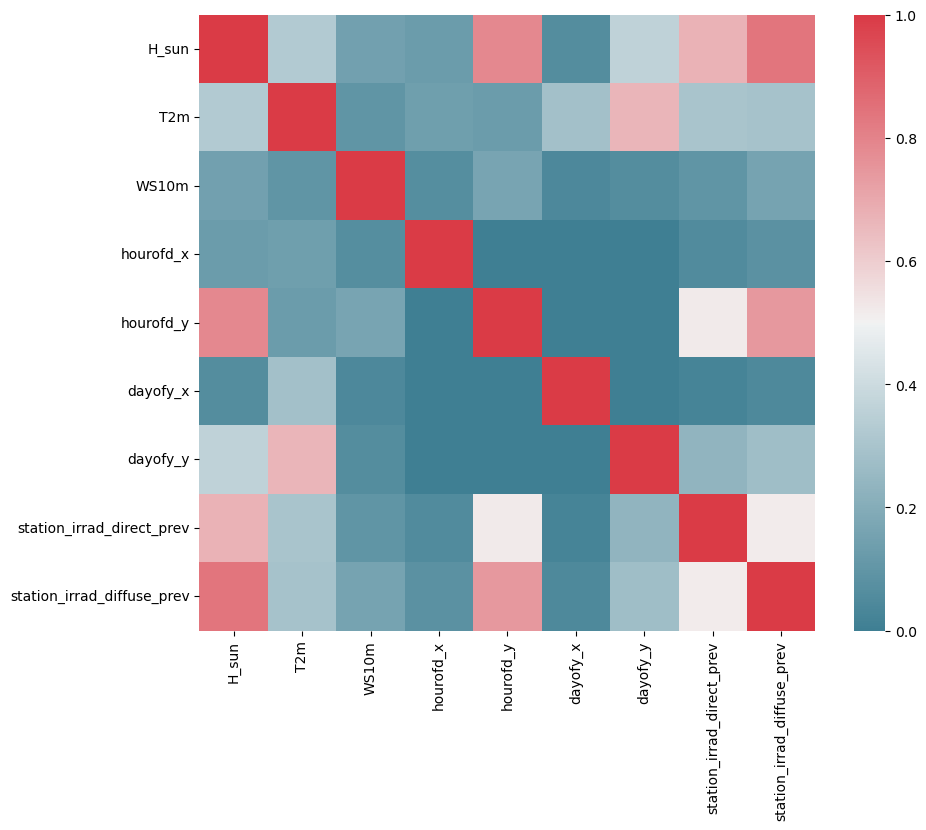

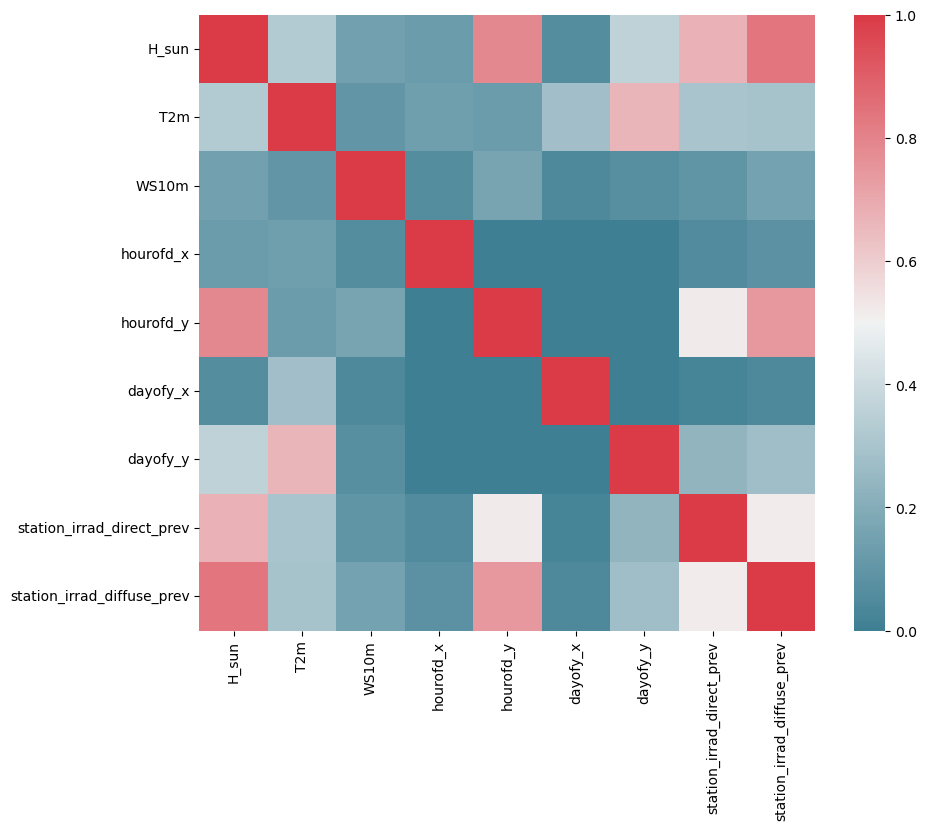

In [5]:
# correlation map between features
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
corr_av = np.zeros((len(non_ar_feat_names), len(non_ar_feat_names)))
for client_num in clients_subset:
    # run correlation matrix and plot
    f, ax = plt.subplots(figsize=(10, 8))
    corr = houses[client_num].data_power.loc[:, non_ar_feat_names].corr()
    corr_av += np.abs(corr)
    sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
corr_av = corr_av/len(clients_subset)

msg = '[RES] observations:'
for row_ind, row in enumerate(corr_av.index):
    for col_ind, col in enumerate(corr_av.columns):
        if row_ind<col_ind:
            if np.abs(corr_av.iloc[row_ind, col_ind])>=0.75:
                msg += '\n' + row + ' and ' + col + ' are highly correlated (|corr|={:0.2f})'.format(np.abs(corr_av.iloc[row_ind, col_ind]))
            elif np.abs(corr_av.iloc[row_ind, col_ind])>=0.5:
                msg += '\n' + row + ' and ' + col + ' are slightly correlated (|corr|={:0.2f})'.format(np.abs(corr_av.iloc[row_ind, col_ind]))
print(msg)


check correlation of each feature with the output

In [6]:
# correlation with the power
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
corr_out = pd.DataFrame(columns = ['Client '+str(client_num) for client_num in clients_subset])
for client_num in clients_subset:    
    corr_out.loc[:, 'Client '+str(client_num)] = houses[client_num].data_power.loc[:, non_ar_feat_names].corrwith(houses[client_num].data_power.loc[:, 'target'])
corr_out['Average'] = corr_out.mean(numeric_only=True, axis=1)
print(corr_out)


msg = '\n[RES] observations:'
for feature in corr_out.index:
    corr_feat = corr_out.loc[feature, 'Average']
    if np.abs(corr_feat)<0.05:
        msg += '\ncorrelation of ' + feature + ' with the output is very low'
print(msg)

                            Client 12  Client 14  Client 15  Client 17  \
H_sun                        0.861097   0.863260   0.867637   0.871614   
T2m                          0.260729   0.283537   0.272573   0.285028   
WS10m                        0.100201   0.121941   0.111428   0.118410   
hourofd_x                    0.153892   0.066432   0.118494   0.090413   
hourofd_y                   -0.672973  -0.686896  -0.679188  -0.682965   
dayofy_x                     0.041960   0.040689   0.042500   0.043266   
dayofy_y                    -0.253741  -0.257936  -0.261215  -0.269729   
station_irrad_direct_prev    0.807202   0.872321   0.840792   0.859937   
station_irrad_diffuse_prev   0.710215   0.741284   0.725584   0.737775   

                            Client 22   Average  
H_sun                        0.857392  0.864200  
T2m                          0.256536  0.271681  
WS10m                        0.103873  0.111171  
hourofd_x                    0.153641  0.116574  
hourofd_y

remove features that are correlated with each other or have a low correlation with the output

['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'dayofy_y', 'station_irrad_direct_prev']


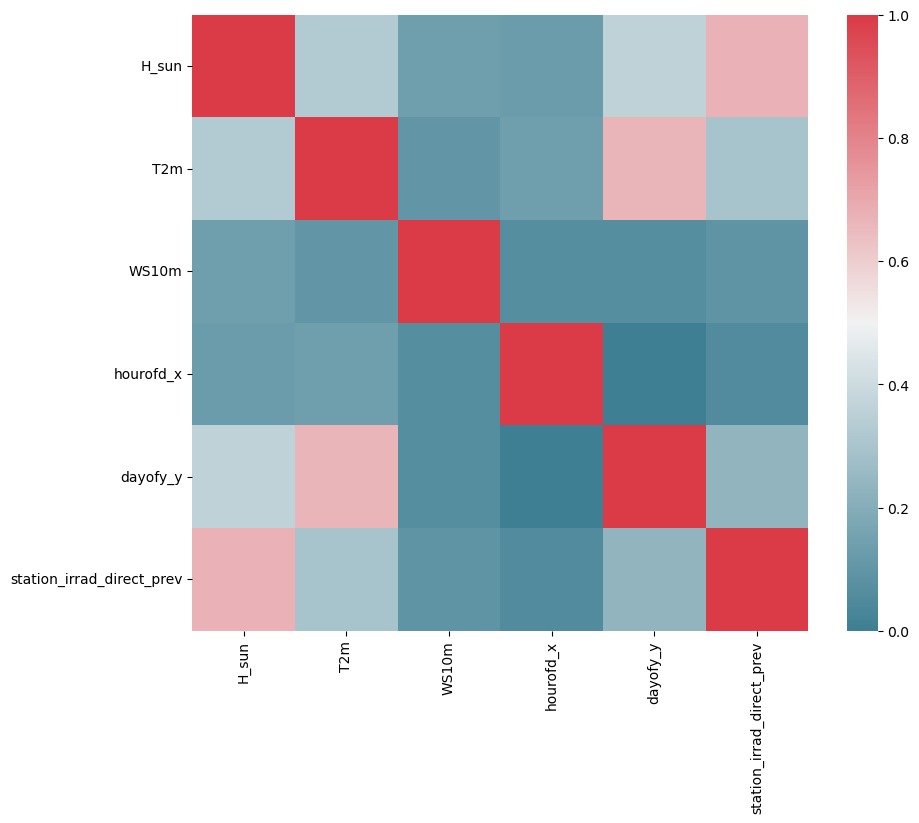

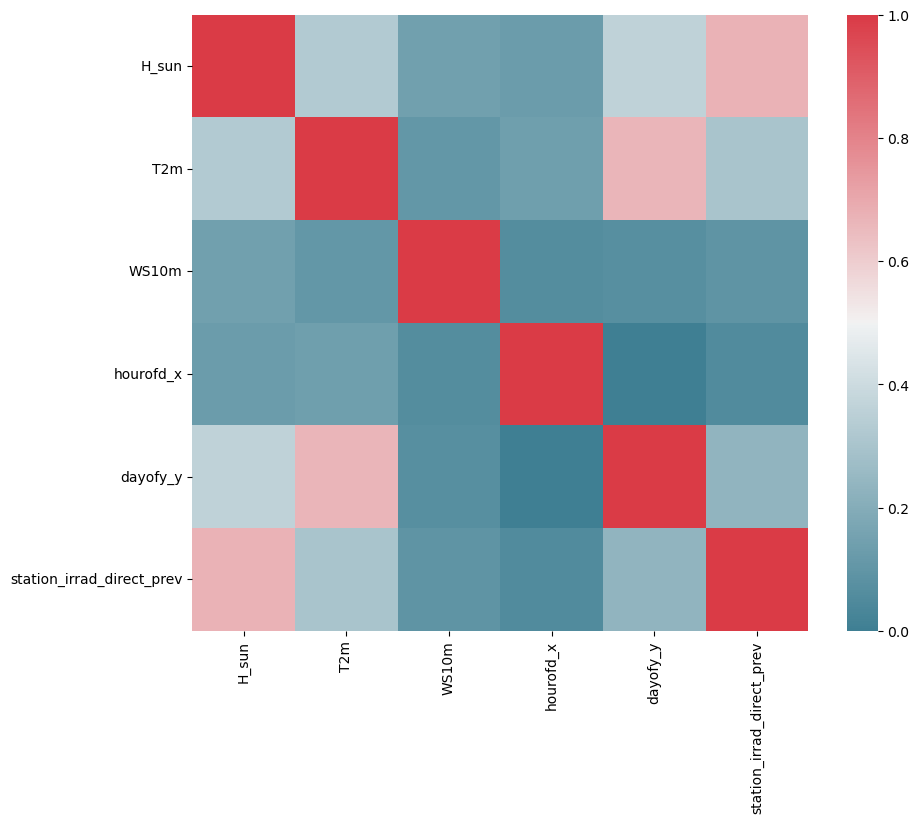

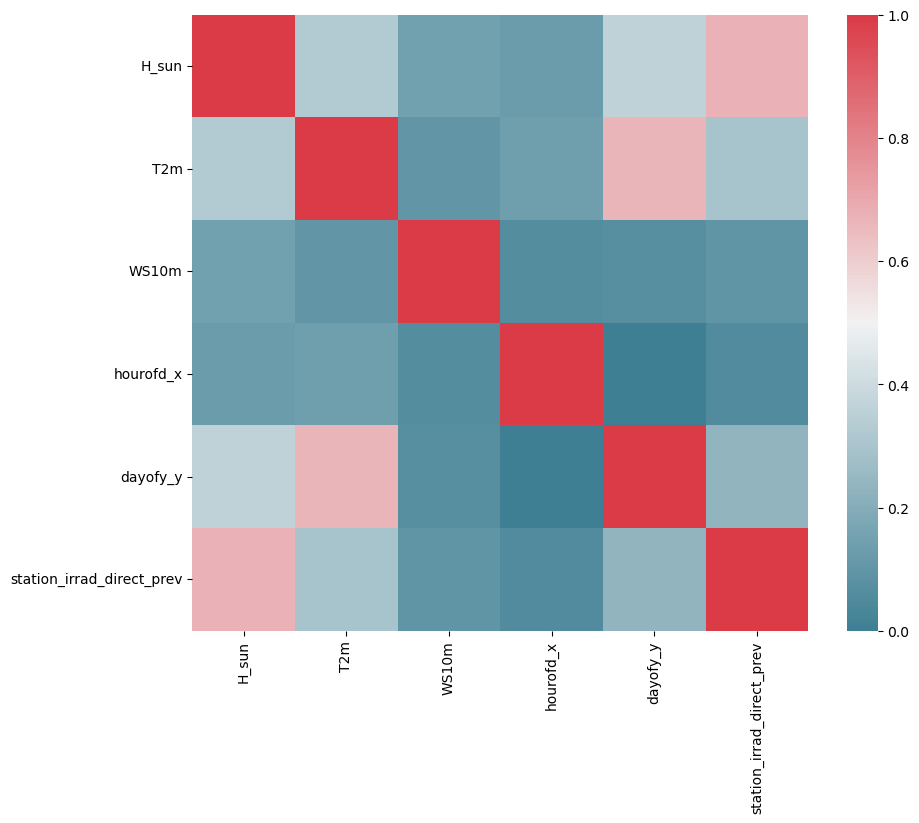

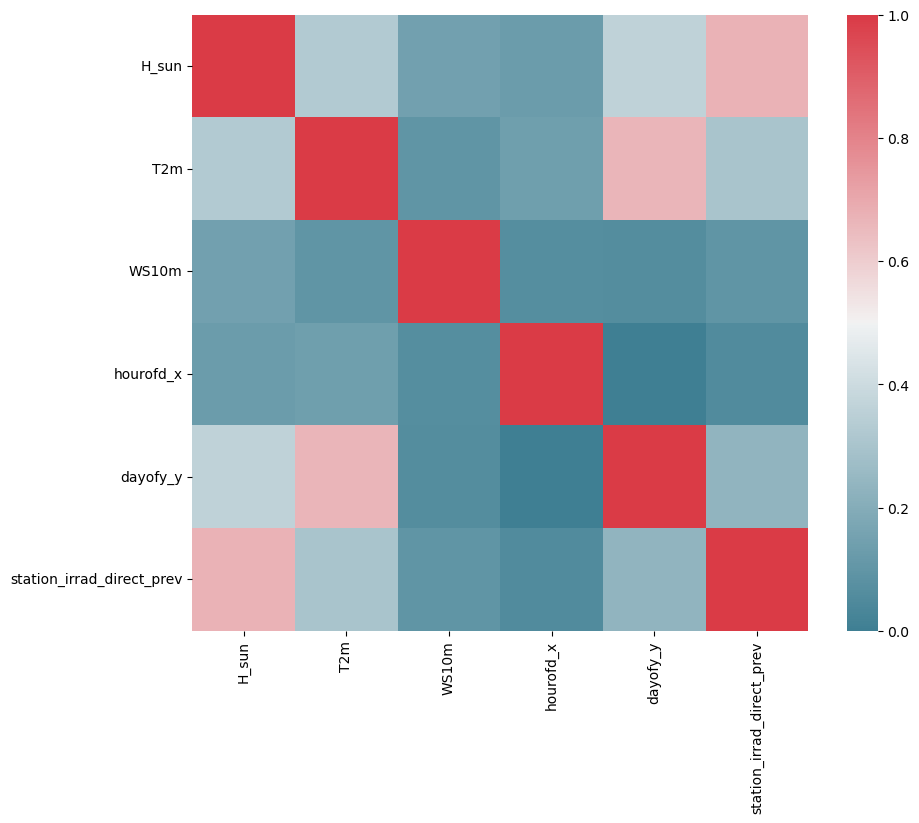

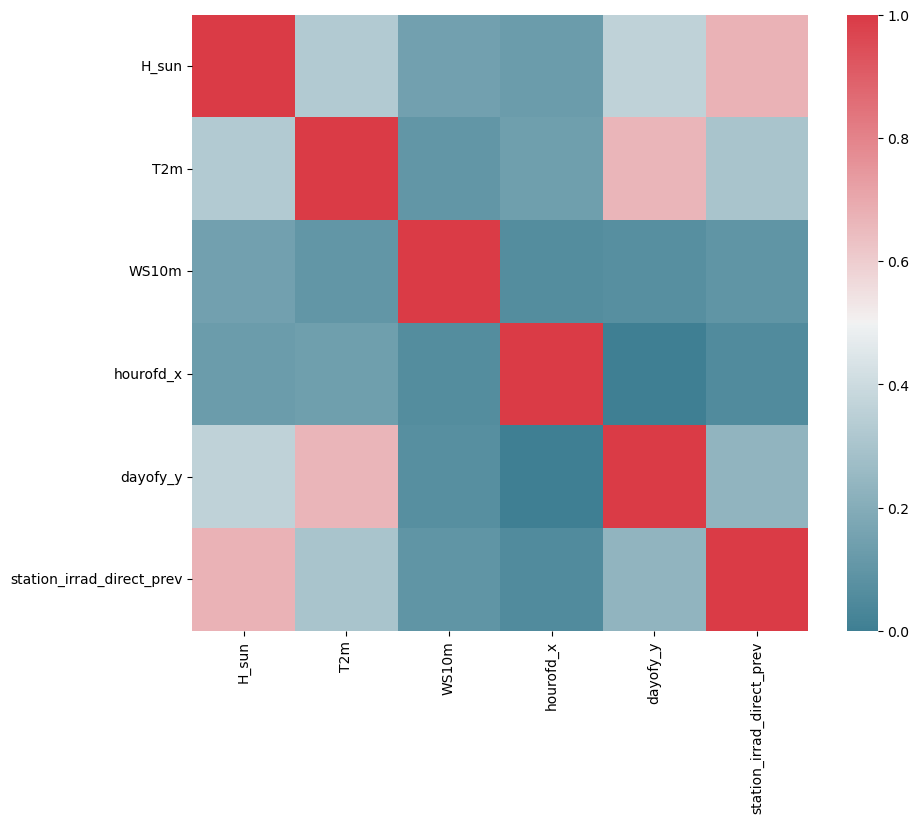

In [7]:
non_ar_feat_remove = ['hourofd_y', 'station_irrad_diffuse_prev', 'dayofy_x']
for feature_name in non_ar_feat_remove:
    remove_feature(
        env_dict=env_dict, 
        feature_name=feature_name, in_place=True)
    for house in houses:
        if not house is None:
            house.feature_names.remove(feature_name)

print(env_dict['feature_names'])
non_ar_feat_names = [x for x in env_dict['feature_names'] if not x.startswith('lag')]
for client_num in clients_subset:
    # run correlation matrix and plot
    f, ax = plt.subplots(figsize=(10, 8))
    corr = houses[client_num].data_power.loc[:, non_ar_feat_names].corr()
    sns.heatmap(np.abs(corr), mask=np.zeros_like(corr, dtype=bool),
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)


# Selecting Features with RFECV
using a Ridge model with tuned penalty every time and Adj R2 scorer

[INFO] the following 63 constnat features were removed:  lag 12 lag 36 lag 60 lag 84 lag 108 lag 132 lag 156 lag 180 lag 204 lag 205 lag 228 lag 229 lag 252 lag 253 lag 276 lag 277 lag 300 lag 301 lag 324 lag 325 lag 348 lag 349 lag 372 lag 373 lag 396 lag 397 lag 420 lag 421 lag 444 lag 445 lag 467 lag 468 lag 469 lag 491 lag 492 lag 493 lag 515 lag 516 lag 517 lag 539 lag 540 lag 541 lag 563 lag 564 lag 565 lag 587 lag 588 lag 589 lag 611 lag 612 lag 613 lag 635 lag 636 lag 637 lag 659 lag 660 lag 661 lag 683 lag 684 lag 685 lag 707 lag 708 lag 709
[INFO] searching among 663 features
[INFO] the following 24 features were selected:
H_sun station_irrad_direct_prev lag 1 lag 2 lag 3 lag 4 lag 19 lag 23 lag 29 lag 30 lag 40 lag 42 lag 671 lag 672


/opt/anaconda3/envs/py3.9.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


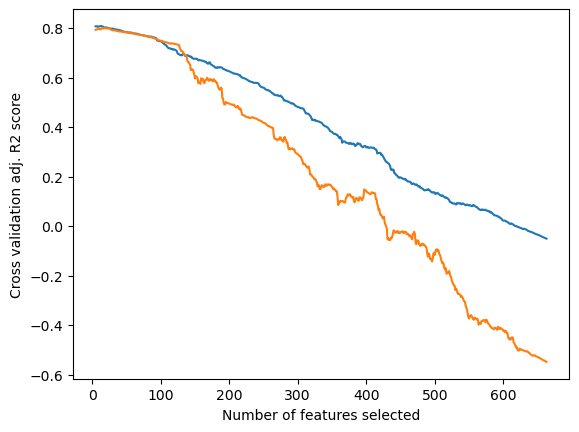

In [8]:
from sklearn.feature_selection import RFECV
from model_training.search_models import RidgeWrapper
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge
from house_pv import _augment_lags, remove_constant_cols


def adj_r2_scorer(estimator, X, y):
    y = y.flatten()
    y_pred = estimator.predict(X).flatten()
    R2 = r2_score(y, y_pred)
    n, p = X.shape
    return 1-(1-R2)*(n-1)/(n-p-1)

run_cell = True
if run_cell:
    # params
    cv = 3
    plot_fig = True
    days_look_back = 24
    keep_non_ar = False # forcee all non-ar features to remain
    min_features_to_select = 5

    # init
    selected_features = [None] * env_dict['num_clients']
    scenario = env_dict['train_scenarios'][scenario_name_recons]

    # all lags to try
    full_lags = np.arange(1, 
                    min(
                        30*days_look_back+1, 
                        math.floor(env_dict['train_scenarios'][scenario_name_recons]['clients_data'][0][0].shape[0]/cv)-1))
    full_lag_names = ['lag ' + str(x) for x in full_lags]

    # search
    for client_num, house in enumerate([houses[clients_subset[0]]]):
        # augment lags
        house.data_power = _augment_lags(
                                house.data_power, 
                                lags=full_lags, 
                                step_ahead=1)
        house.feature_names += full_lag_names
        for x in non_ar_feat_remove:
            assert not x in house.feature_names

        # construct regression matrices
        data_tuple = house.construct_regression_matrices(
                                m_train=scenario['m_train'],
                                train_years=scenario['train_years'],
                                exclude_last_year=scenario['exclude_last_year'])

        # remove constant lags
        house.data_power, data_tuple, house.feature_names = remove_constant_cols(
                                data_power=house.data_power, 
                                data_tuple=data_tuple, 
                                feature_names=house.feature_names)
        print('[INFO] searching among {:2.0f} features'.format(len(house.feature_names)))
        
        # fit Ridge regression with Grid search over penalty
        ridge_wrapper = RidgeWrapper(alphas=np.logspace(-6,2,20)) 
        
        # fit RFECV
        X_train, y_train, X_valid, y_valid = data_tuple
        selector = RFECV(
                    estimator=ridge_wrapper, step=1, cv=cv, 
                    scoring=adj_r2_scorer, 
                    min_features_to_select=min_features_to_select) 
        selector = selector.fit(X_train, y_train.flatten())
        
        #Force every non-lag feature to be in the RFECV
        if keep_non_ar:
            for i, feature_name in enumerate(house.feature_names):
                if not feature_name.startswith('lag'):
                    selector.support_[i] = True
                    
        selected_features[client_num] = [house.feature_names[i] for i, x in enumerate(selector.support_) if x]
        print('[INFO] the following {:2.0f} features were selected:'.format(len(selected_features)))
        print(*selected_features[client_num])

        # Plot number of features VS. cross-validation scores
        if plot_fig:
            plt.figure()
            plt.xlabel("Number of features selected")
            plt.ylabel("Cross validation adj. R2 score")
            plt.plot(range(min_features_to_select,
                            len(selector.grid_scores_) + min_features_to_select),
                        selector.grid_scores_)
            plt.show()


    # save
    file = open(os.getcwd() + "/../../saved_results/" + exp_name + "_feat_eng", 'wb')
    pickle.dump(
        {'selected_features':selected_features}, 
        file)
# load
else:
    file = open(os.getcwd() + "/../../saved_results/" + exp_name + "_feat_eng", 'rb')
    res = pickle.load(file)
    print(res.keys())
    selected_features = res['selected_features']
file.close()



In [11]:
# save
exp_name = 'PV_Unimodal'
file = open(os.getcwd() + "/../../saved_results/" + exp_name + "_feat_eng", 'wb')
pickle.dump(
    {'selected_features':selected_features}, 
    file)

### Feature Selection using PACF

[INFO] the following constnat features were removed:  lag 12 lag 180 lag 108 lag 467 lag 228 lag 252 lag 587 lag 611 lag 348 lag 373 lag 325 lag 156 lag 60 lag 563 lag 516 lag 301 lag 84 lag 492 lag 276 lag 253 lag 132 lag 204 lag 420 lag 539 lag 684 lag 564 lag 277 lag 349 lag 659 lag 324 lag 372 lag 683 lag 565 lag 468 lag 515 lag 708 lag 636 lag 396 lag 589 lag 661 lag 660 lag 540 lag 300 lag 444 lag 397 lag 421 lag 612 lag 469 lag 491 lag 613 lag 445 lag 707 lag 685 lag 493 lag 709 lag 541 lag 635 lag 517 lag 36 lag 588 lag 637
[INFO] sorted lags after removing constant lags during training:  1 2 3 20 19 21 18 22 17 4 23 10 25 45 9 46 44 11 69 70 47 68 16 43 8 49 26 93 13 118 73 94 71 67 117 27 116 142 166 95 92 167 190 50 97 165 141 14 214 145 121 143 42 189 91 169 140 74 119 213 262 66 164 115 51 48 188 139 337 163 237 6 217 383 72 265 144 478 287 191 285 40 260 433 239 211 212 406 238 479 575 34 236 215 284 122 286 261 33 481 193 98 30 476 114 380 90 670 259 359 431 381 308 457 

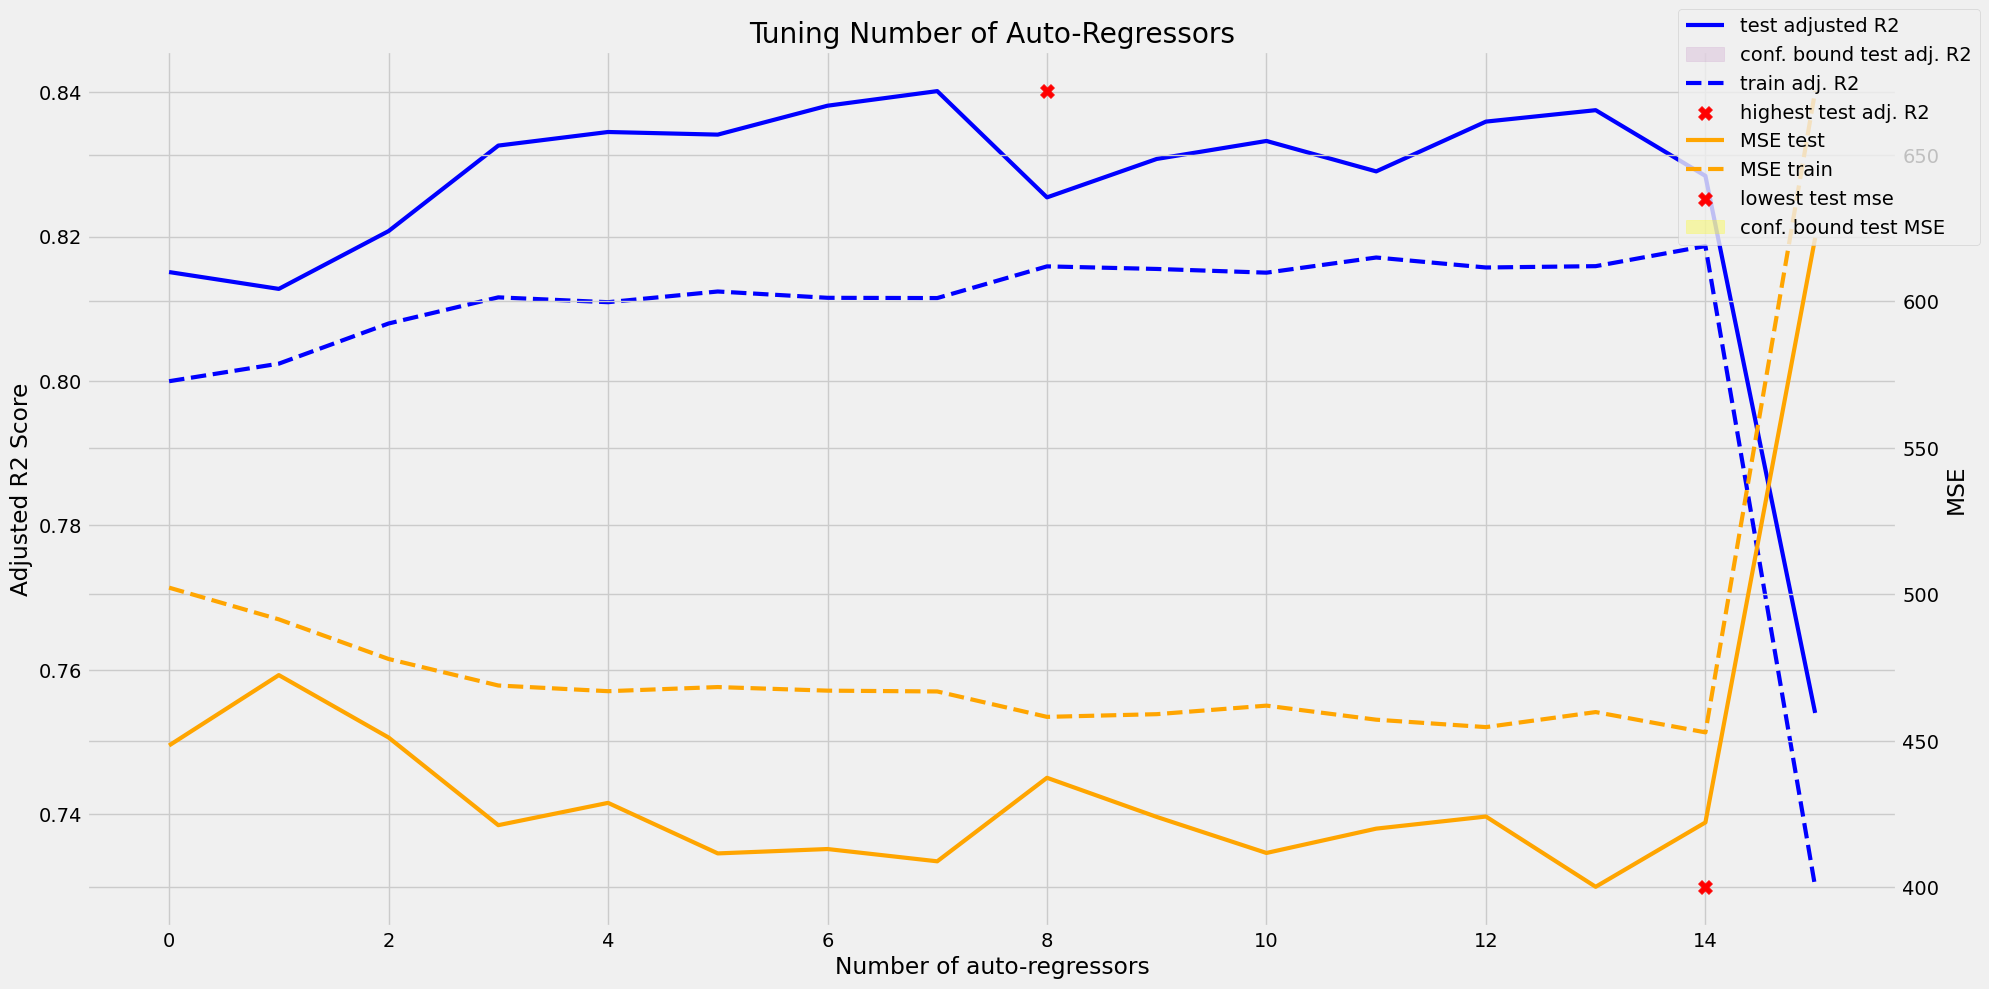

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			8				0.8401			0.9511		408.8918
min MSE:			14				0.8375			12.9942		400.1930
first in range:			4				0.8326			-7.1083		421.2270
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3 20
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22
(139535, 673)
[INFO] the following constnat features were removed:  lag 12 lag 467 lag 563 lag 587 lag 325 lag 301 lag 180 lag 611 lag 491 lag 36 lag 707 lag 469 lag 277 lag 373 lag 349 lag 492 lag 253 lag 683 lag 539 lag 420 lag 659 lag 515 lag 516 lag 421 lag 132 lag 108 lag 252 lag 468 lag 84 lag 635 lag 60 lag 637 lag 228 lag 276 lag 564 lag 636 lag 156 lag 348 lag 397 lag 684 lag 517 lag 493 lag 709 lag 661 lag 444 lag 324 lag 708 lag 613 lag 589 lag 541 lag 565 lag

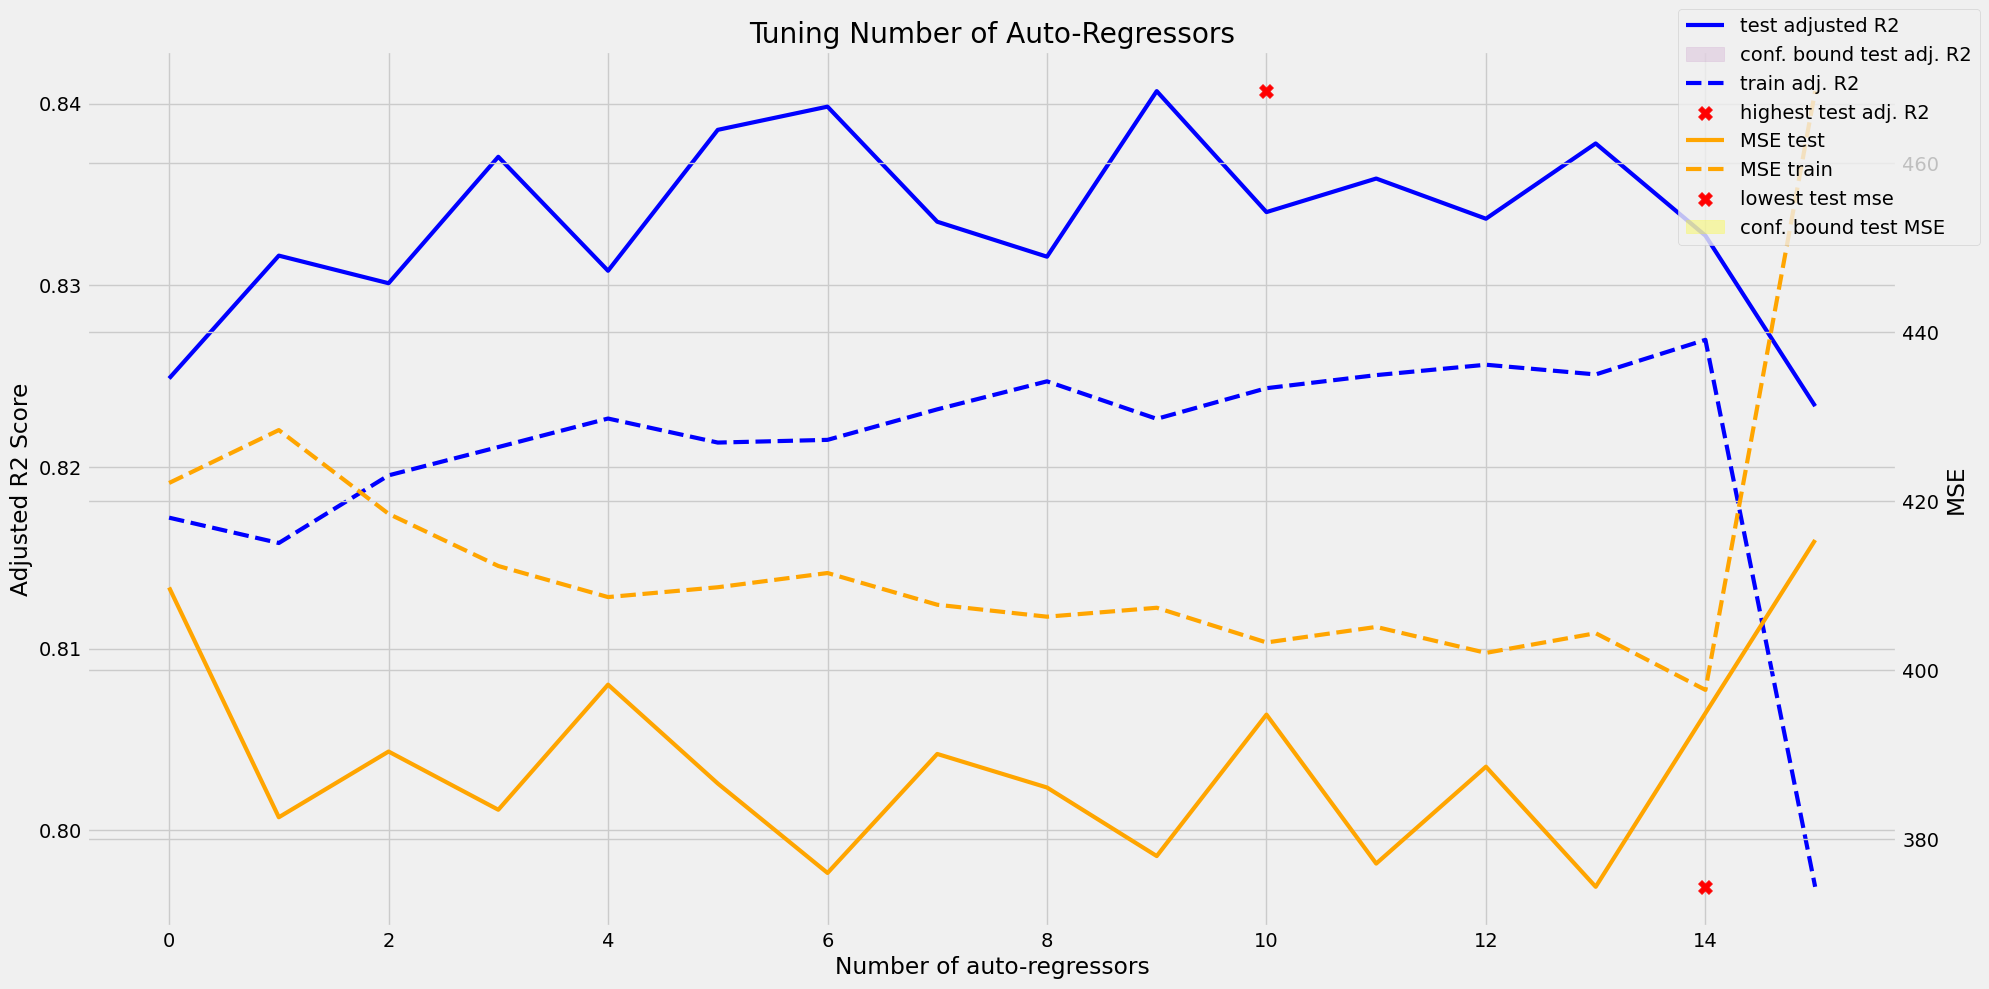

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			10				0.8407			5.1062		377.9700
min MSE:			14				0.8378			13.1256		374.3326
first in range:			1				0.8249			-13.0553		409.7561
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 17 4
(140255, 16)
[INFO] the following constnat features were removed:  lag 12 lag 180 lag 611 lag 36 lag 467 lag 563 lag 587 lag 539 lag 252 lag 108 lag 228 lag 492 lag 516 lag 325 lag 132 lag 420 lag 276 lag 373 lag 301 lag 636 lag 684 lag 348 lag 156 lag 564 lag 349 lag 659 lag 60 lag 683 lag 707 lag 84 lag 515 lag 277 lag 204 lag 468 lag 491 lag 253 lag 708 lag 660 lag 469 lag 324 lag 540 lag 372 lag 421 lag 661 lag 635 lag 612 lag 565 lag 444 lag 396 lag 589 lag 517 lag 

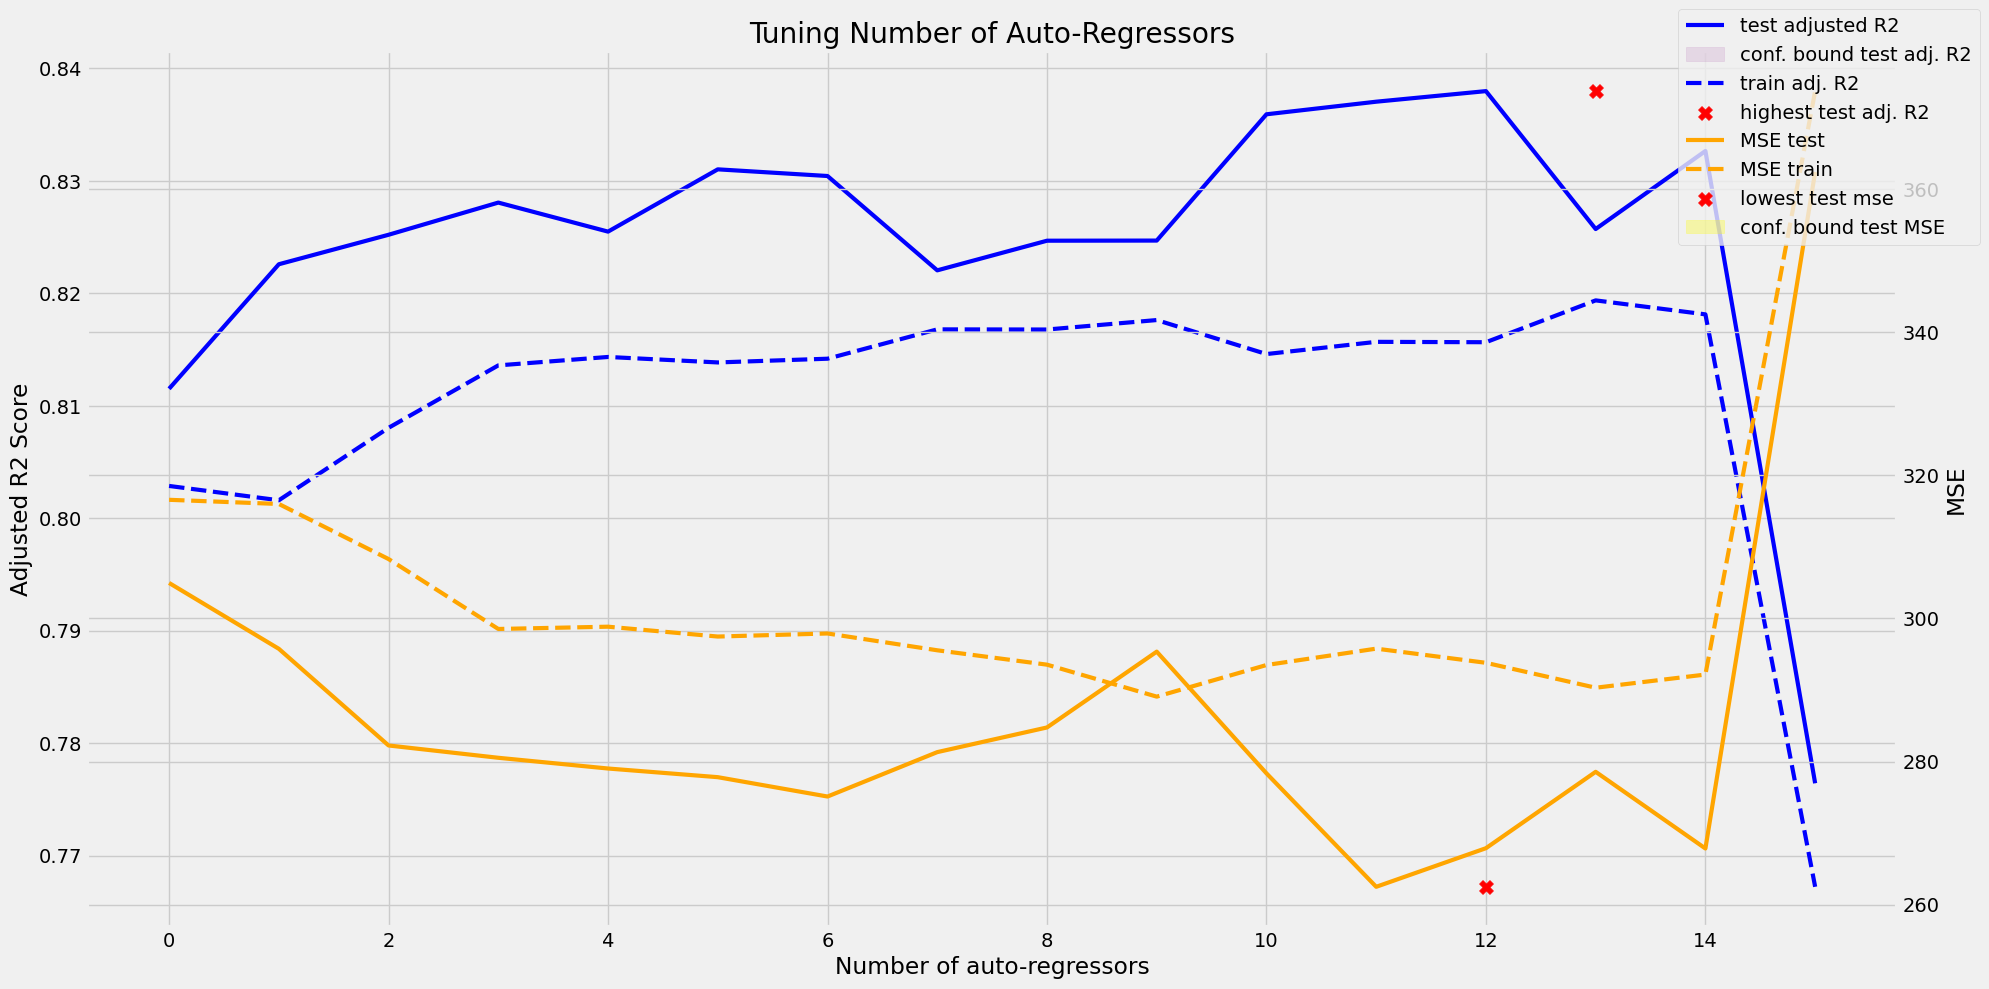

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			13				0.8380			11.7947		267.8878
min MSE:			12				0.8370			9.8354		262.4927
first in range:			3				0.8252			-8.3097		282.2440
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2 3
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 17 4 23 10 45
(140255, 16)
[INFO] the following constnat features were removed:  lag 12 lag 36 lag 563 lag 467 lag 587 lag 180 lag 611 lag 539 lag 492 lag 707 lag 516 lag 325 lag 683 lag 252 lag 108 lag 132 lag 301 lag 659 lag 228 lag 420 lag 515 lag 491 lag 349 lag 276 lag 373 lag 636 lag 564 lag 684 lag 468 lag 348 lag 277 lag 84 lag 469 lag 156 lag 635 lag 421 lag 660 lag 708 lag 60 lag 253 lag 444 lag 540 lag 324 lag 204 lag 661 lag 709 lag 612 lag 517 lag 372 lag 493 

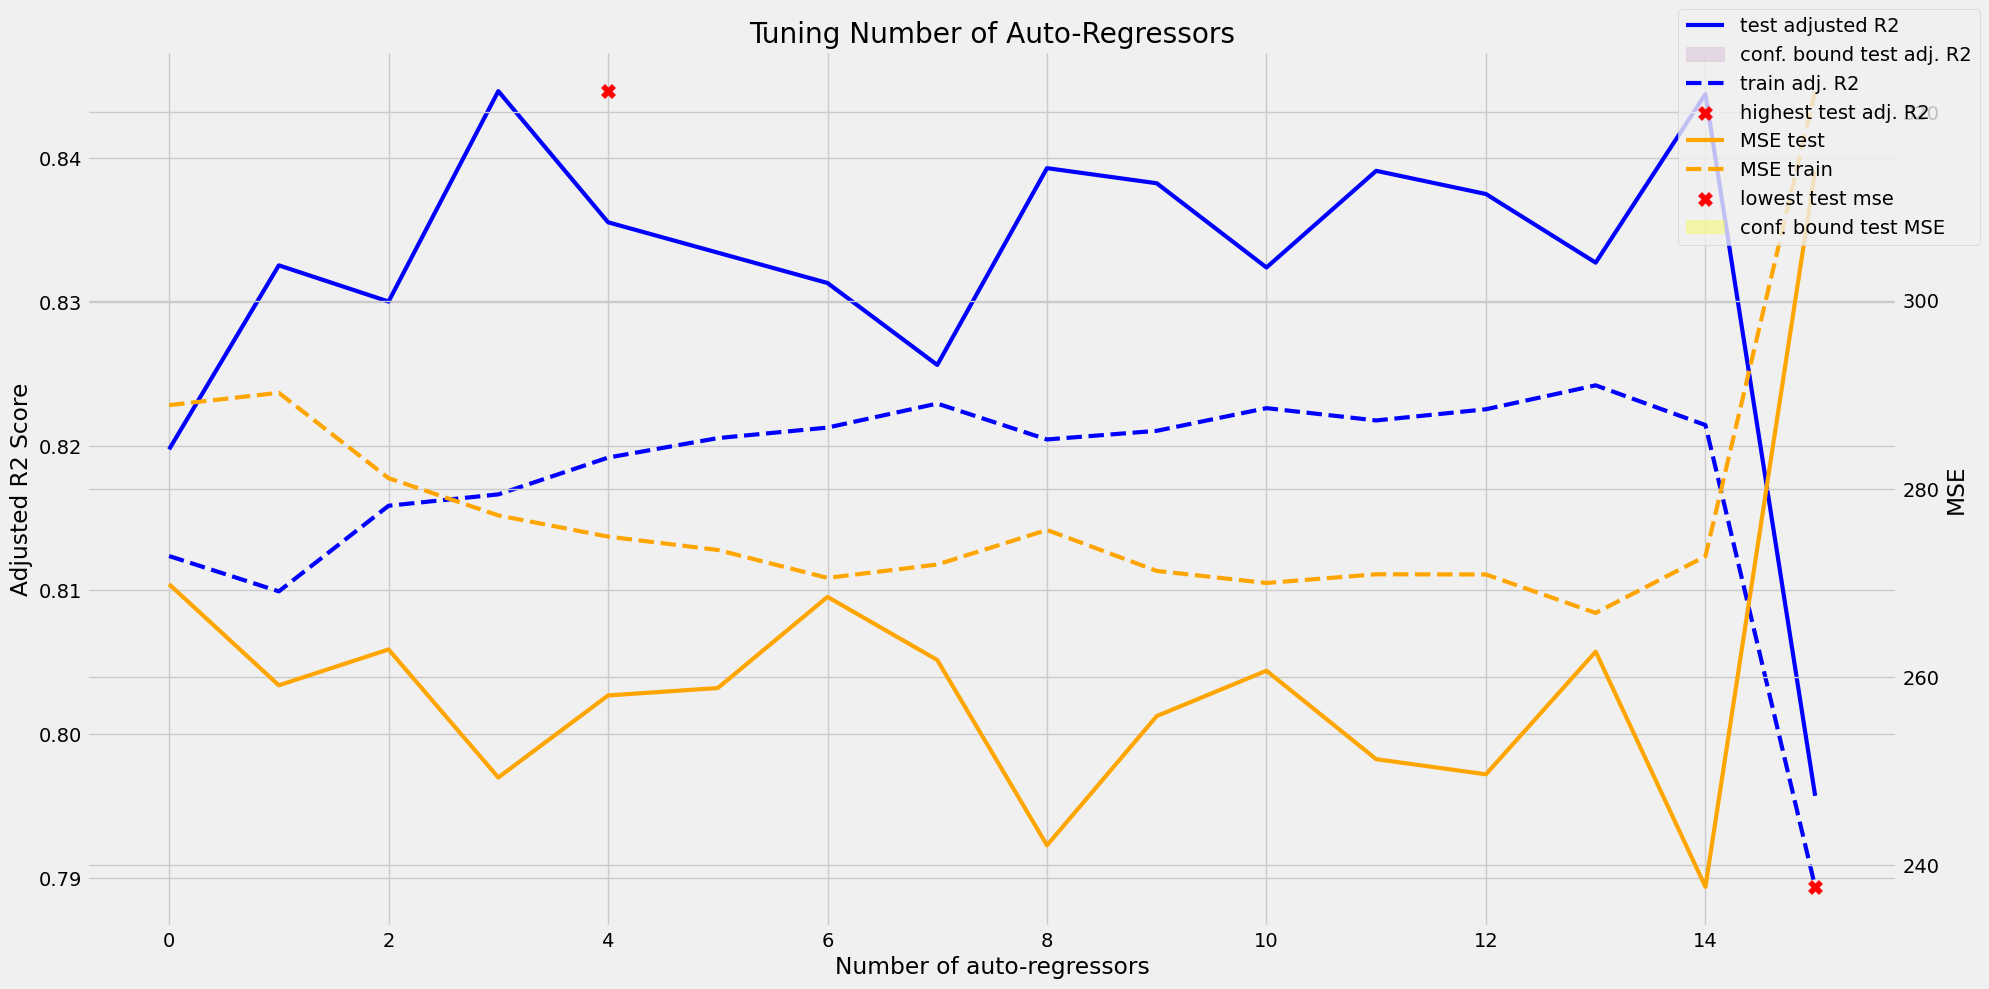

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			4				0.8447			-6.0617		249.3275
min MSE:			15				0.8445			16.0337		237.7159
first in range:			2				0.8326			-10.1388		259.1278
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1 2
[RES] lags by lowest adj r2:  1 2 3 20
(140255, 16)
[INFO] the following constnat features were removed:  lag 12 lag 180 lag 108 lag 467 lag 228 lag 252 lag 60 lag 587 lag 373 lag 84 lag 348 lag 276 lag 156 lag 204 lag 325 lag 132 lag 492 lag 563 lag 611 lag 301 lag 516 lag 253 lag 420 lag 539 lag 277 lag 372 lag 324 lag 349 lag 684 lag 564 lag 659 lag 468 lag 515 lag 565 lag 300 lag 683 lag 396 lag 636 lag 661 lag 589 lag 708 lag 444 lag 612 lag 540 lag 613 lag 469 lag 491 lag 397 lag 660 lag 421 lag 445 lag 541 lag 493 la

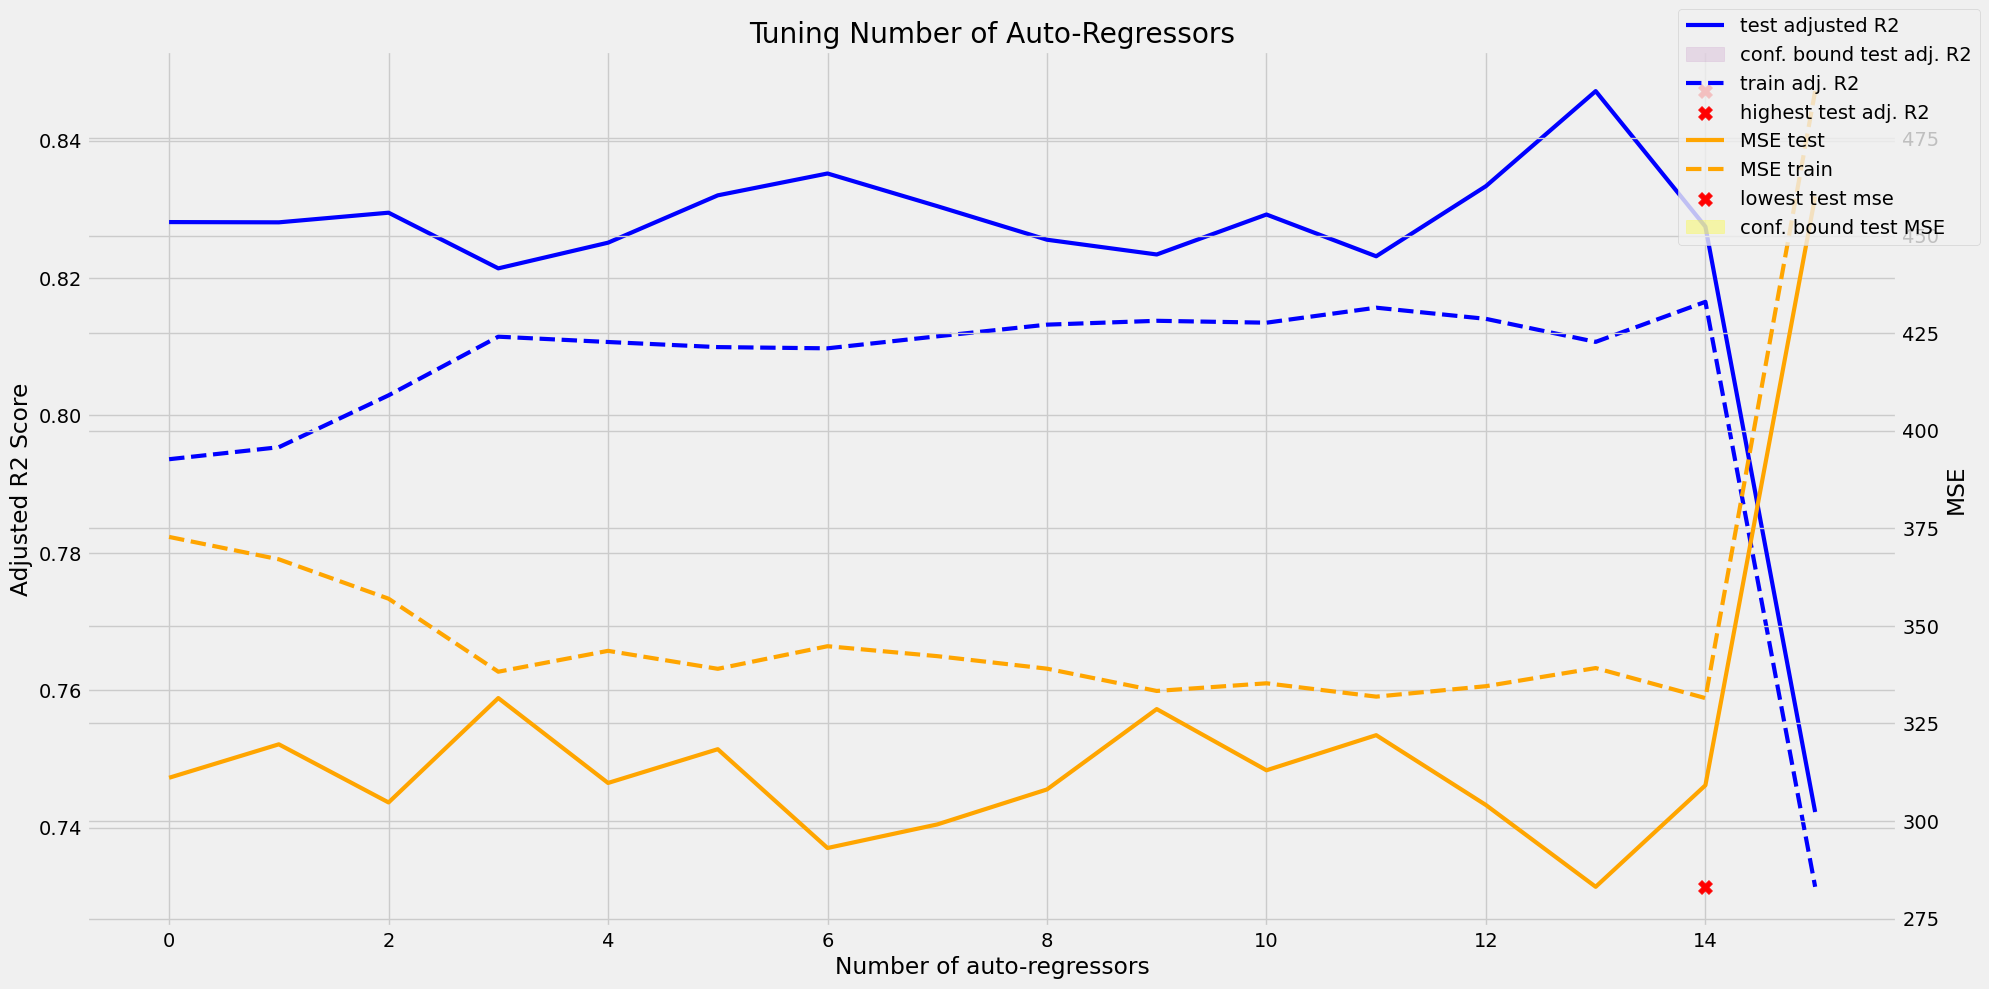

Results:
Criterion			Num.auto-regressors		Adj. R2 test		AIC test	MSE test
-------------------------------------------------------------------------------------------------------------
max adj. R2:			14				0.8472			13.6840		283.1373
min MSE:			14				0.8472			13.6840		283.1373
first in range:			1				0.8281			-12.5042		311.0728
-------------------------------------------------------------------------------------------------------------
[RES] lags by first in range:  1
[RES] lags by lowest adj r2:  1 2 3 20 19 21 18 22 17 23 4 25 10 45
(140255, 16)


In [10]:
# selecting the lags
first_in_range, best_num_r = [None]*env_dict['num_clients'], [None]*env_dict['num_clients']
best_num_m, sorted_lags = [None]*env_dict['num_clients'], [None]*env_dict['num_clients']
for client_num in clients_subset:
    first_in_range[client_num], best_num_r[client_num], best_num_m[client_num], sorted_lags[client_num] = tune_pacf(
                    house=houses[client_num], max_num_lags=15, max_num_days=30,
                    step_ahead=1, repeats=1, verbose=True)
    print('[RES] lags by first in range: ', *sorted_lags[client_num][:first_in_range[client_num]])
    print('[RES] lags by lowest adj r2: ', *sorted_lags[client_num][:best_num_r[client_num]])
    print(houses[client_num].data_power.shape)
